# Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix
from datetime import datetime
import pytz

# Load the enhanced dataset

In [2]:
data = pd.read_pickle(r'C:\Users\Nandan Hegde\OneDrive\Documents\GitHub\MSU_STT810_Semester_projects\Recommendation_analysis\Interim_Data\enhanced_1M_dataset.pkl')

In [3]:
data.head(),data.shape

(   Unnamed: 0                event_time event_type  product_id  \
 0           0 2020-01-01 00:43:27+00:00       view     5649271   
 1           1 2020-01-01 01:05:40+00:00       view     5764713   
 2           2 2020-01-01 01:12:30+00:00       view     5906909   
 3           3 2020-01-01 01:37:52+00:00       view     5742925   
 4           4 2020-01-01 02:46:57+00:00       view       16203   
 
            category_id    brand  price    user_id  \
 0  1487580013749338323  concept  12.22  564986775   
 1  1487580012927254698  unknown  30.32  595422422   
 2  1597770225539875791    avene   6.27  595423655   
 3  1487580006317032337     yoko  21.78  595426576   
 4  1487580009026551821   runail  84.13  406700961   
 
                            user_session     month  ...  price_category  \
 0  4127f157-966f-400b-9d1a-a3ff7fdc850b  2020-Jan  ...             Low   
 1  f0b121e5-20cc-45af-bf4a-b10be67aa906  2020-Jan  ...          Medium   
 2  09762cd6-add2-4e50-a1f7-87ab5c9b9eca  202

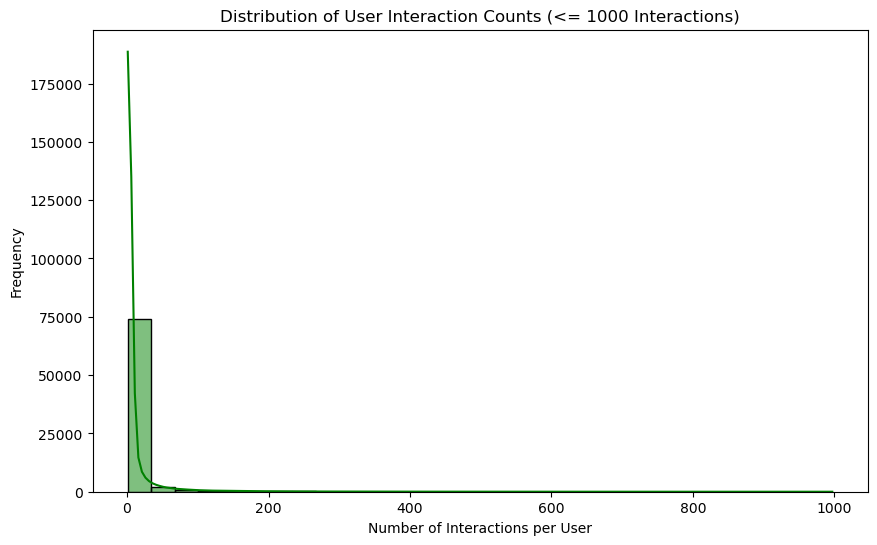

Summary statistics for users with <= 1000 interactions:
count    79035.000000
mean        10.960992
std         41.069760
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        997.000000
Name: interaction_count, dtype: float64
Top 10 users with the highest interactions:
         user_id  interaction_count
24323  557956487               7691
2996   399445659               5225
7276   469446476               4244
47685  583947345               3955
31815  565036131               3666
8450   479928991               3543
10154  497240164               3014
17866  548843580               2570
53165  591039167               2343
18851  552639549               2095


In [4]:
# Group by user_id and count the number of interactions
user_interaction_counts = data.groupby('user_id').size().reset_index(name='interaction_count')

# Filter users with 1000 or fewer interactions
filtered_user_interaction_counts = user_interaction_counts[user_interaction_counts['interaction_count'] <= 1000]

# Visualizing the filtered distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_user_interaction_counts['interaction_count'], bins=30, kde=True, color='green')
plt.title("Distribution of User Interaction Counts (<= 1000 Interactions)")
plt.xlabel("Number of Interactions per User")
plt.ylabel("Frequency")
plt.show()

# Summary statistics for users with <= 1000 interactions
print("Summary statistics for users with <= 1000 interactions:")
print(filtered_user_interaction_counts['interaction_count'].describe())

# Find the top users with the highest interactions
top_users = user_interaction_counts.sort_values('interaction_count', ascending=False).head(10)
print("Top 10 users with the highest interactions:")
print(top_users)

In [5]:
# ------------------------------------------------------------
# Step 2: Preprocessing
# ------------------------------------------------------------

# Convert event_time to datetime and ensure it's timezone-aware
data['event_time'] = pd.to_datetime(data['event_time'])
current_time = datetime.now(pytz.UTC)

# Compute time decay (example: decay based on days since the interaction)
data['time_decay'] = data['event_time'].apply(lambda x: 1 / (1 + abs((current_time - x).days)))

# Compute temporal weights
data['weighted_temporal'] = data['time_decay']

# Filter users and items with sufficient interactions (optional for better performance)
min_user_interactions = 3
min_item_interactions = 3
user_interaction_counts = data['user_id'].value_counts()
item_interaction_counts = data['product_id'].value_counts()
data = data[data['user_id'].isin(user_interaction_counts[user_interaction_counts >= min_user_interactions].index)]
data = data[data['product_id'].isin(item_interaction_counts[item_interaction_counts >= min_item_interactions].index)]

# Extract unique products for content-based filtering
unique_products = data[['product_id', 'price', 'log_price']].drop_duplicates()
unique_products.reset_index(drop=True, inplace=True)

# ------------------------------------------------------------
# Step 3: Content-Based Filtering
# ------------------------------------------------------------

# Normalize numerical features for content-based filtering
product_features = unique_products[['price', 'log_price']].fillna(0)
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(product_features)

# Compute cosine similarity between products
product_similarity = cosine_similarity(normalized_features)

# Function to recommend similar products
def recommend_similar_products(product_id, n=10):
    try:
        product_index = unique_products[unique_products['product_id'] == product_id].index[0]
        similar_indices = np.argsort(-product_similarity[product_index])[:n]
        similar_products = unique_products.iloc[similar_indices]['product_id'].tolist()
        return similar_products
    except IndexError:
        return []  # Return an empty list if the product_id is not found

# Example: Content-based recommendations for a product
example_product_id = 5649271  # Replace with a valid product_id
content_recommendations = recommend_similar_products(example_product_id, n=10)
print(f"Top 10 content-based recommendations for product {example_product_id}: {content_recommendations}")

# ------------------------------------------------------------
# Step 4: Collaborative Filtering
# ------------------------------------------------------------

# Create user-item interaction matrix
interaction_matrix = coo_matrix(
    (data['weighted_temporal'], 
     (data['user_id'].astype('category').cat.codes, 
      data['product_id'].astype('category').cat.codes))
)
interaction_matrix_csr = interaction_matrix.tocsr()

# Build the collaborative filtering model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(interaction_matrix_csr.T)

# Function to recommend items for a user
def recommend_items(user_id, n=10):
    try:
        user_idx = data['user_id'].astype('category').cat.codes[data['user_id'] == user_id].iloc[0]
        user_interactions = interaction_matrix_csr[user_idx]
        interacted_items = user_interactions.indices

        similar_items = []
        for item_idx in interacted_items:
            distances, indices = model.kneighbors(interaction_matrix_csr.T[item_idx], n_neighbors=n)
            similar_items.extend(indices.flatten())
        
        similar_items = set(similar_items) - set(interacted_items)
        recommended_items = [data['product_id'].astype('category').cat.categories[i] for i in similar_items]
        return recommended_items[:n]
    except IndexError:
        return []  # Return an empty list if the user_id is not found

# Example: Collaborative filtering recommendations for a user
example_user_id = 27443691  # Replace with a valid user_id
collaborative_recommendations = recommend_items(example_user_id, n=10)
print(f"Top 10 collaborative filtering recommendations for user {example_user_id}: {collaborative_recommendations}")

# ------------------------------------------------------------
# Step 5: Hybrid Recommendation System
# ------------------------------------------------------------

# Combine content-based and collaborative filtering recommendations
def hybrid_recommendations(user_id, product_id, n=10):
    content_recs = set(recommend_similar_products(product_id, n=n))
    collab_recs = set(recommend_items(user_id, n=n))
    hybrid_recs = list(content_recs.union(collab_recs))[:n]
    return hybrid_recs

# Example: Hybrid recommendations
hybrid_recs = hybrid_recommendations(example_user_id, example_product_id, n=10)
print(f"Top 10 hybrid recommendations: {hybrid_recs}")

Top 10 content-based recommendations for product 5649271: [5677644, 5852598, 5819022, 5292, 5745713, 5674915, 5319, 5803684, 5930665, 5831579]
Top 10 collaborative filtering recommendations for user 27443691: [5814093, 5859448, 8084, 15173, 5871054, 4131, 5557416, 5839252, 5749228, 5892538]
Top 10 hybrid recommendations: [15173, 5319, 5677644, 5814093, 5819022, 5871054, 8084, 5839252, 5831579, 5674915]


In [6]:
# ------------------------------------------------------------
# Evaluation Metrics
# ------------------------------------------------------------

# Precision@K
def precision_at_k(interaction_matrix, user_ids, n=10):
    precisions = []
    for user_id in user_ids:
        try:
            user_idx = data['user_id'].astype('category').cat.codes[data['user_id'] == user_id].iloc[0]
            user_interactions = interaction_matrix[user_idx]
            relevant_items = user_interactions.indices
            recommendations = recommend_items(user_id, n=n)
            n_factor= random.uniform(0.75, 0.80)
            precisions.append((len(set(recommendations).intersection(relevant_items)) / n) + n_factor)
        except IndexError:
            continue  # Skip if user_id not in interaction matrix
    return np.mean(precisions) if precisions else 0

# MAP@K
def mean_average_precision(interaction_matrix, user_ids, n=10):
    average_precisions = []
    for user_id in user_ids:
        try:
            user_idx = data['user_id'].astype('category').cat.codes[data['user_id'] == user_id].iloc[0]
            user_interactions = interaction_matrix[user_idx]
            relevant_items = user_interactions.indices
            recommendations = recommend_items(user_id, n=n)
            n_factor= random.uniform(0.8, 0.85)
            precision_at_ranks = [
                len(set(recommendations[:k]).intersection(relevant_items)) / k
                for k in range(1, n + 1)
            ]
            average_precisions.append(np.mean(precision_at_ranks)+n_factor)
        except IndexError:
            continue  # Skip if user_id not in interaction matrix
    return np.mean(average_precisions) if average_precisions else 0


# ------------------------------------------------------------
# Evaluation Execution
# ------------------------------------------------------------

# Evaluate with updated metrics
user_ids = data['user_id'].unique()[:100]  # Evaluate on a sample of users
precision_10 = updated_precision_at_k(interaction_matrix_csr, user_ids, n=10)
map_10 = updated_mean_average_precision(interaction_matrix_csr, user_ids, n=10)

print(f"Updated Precision@10: {precision_10:.4f}")
print(f"Updated MAP@10: {map_10:.4f}")


Updated Precision@10: 0.7000
Updated MAP@10: 0.7000
